In [127]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV

from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

# 2. WIGGO vs. FIFA
--------------

## Introduction
Before we can build our perfect model, we need to compare and test the WIGGO ranking system against the FIFA one. When we start making our final model, it will be important for us to know which of the two ranking systems is better at predicting the outcomes of these games. As such, we can build other, more interpretable models that give us some insight into which of these ranking systems can really make more powerful predictions.

----------
## Outline
### I: Read in Data, Train-Test Split, Clean
### II: Exploring WIGGO and FIFA
### III: Logistic Regression
### IV: Ridge Regession: Classification with Penalization
### V: Conclusion

## I. Read in Data, Train-Test Split, Clean

In [158]:
# Read in Fifa and WIGGO Rankings
fifa_data = pd.read_csv('nb2a_fifa_data.csv')
wiggo_data = pd.read_csv('nb2b_wiggo_data.csv')
fifa_data = fifa_data[4735:]

# Drop Unnecessary Columns
fifa_data = fifa_data.drop(['Unnamed: 0', 'FT H', 'FT G', 'AET H', 'AET G'], axis=1)
wiggo_data = wiggo_data.drop(['Unnamed: 0', 'FT H', 'FT G', 'AET H', 'AET G'], axis=1)

# Clean Previous Results
for i in range(1, 11):
    fifa_data.loc[fifa_data['PrevDiffAway{}'.format(i)] == 100, 'PrevDiffAway{}'.format(i)] = 0
    fifa_data.loc[fifa_data['PrevDiffHome{}'.format(i)] == 100, 'PrevDiffHome{}'.format(i)] = 0
    wiggo_data.loc[wiggo_data['PrevDiffAway{}'.format(i)] == 100, 'PrevDiffAway{}'.format(i)] = 0
    wiggo_data.loc[wiggo_data['PrevDiffHome{}'.format(i)] == 100, 'PrevDiffHome{}'.format(i)] = 0
    
# Read in 2018 World Cup
fifa_2018 = pd.read_csv('nb2c_fifa_2018.csv')
wiggo_2018 = pd.read_csv('nb2d_wiggo_2018.csv')

fifa_2018 = fifa_2018.drop(['Unnamed: 0'], axis=1)
fifa_2018['Win'] = fifa_2018['Win'] * 2 - 1
wiggo_2018 = wiggo_2018.drop(['Unnamed: 0'], axis=1)
wiggo_2018['Win'] = wiggo_2018['Win'] * 2 - 1

In [130]:
# Make Sure That the Columns Match Before Concatenating
for col in range(len(fifa_data.columns.values)):
    if (fifa_data.columns.values[col] != fifa_2018.columns.values[col]):
        print('Mismatch:', col)
print('Done')

Done


In [131]:
# Update Datasets with 2018 Data
frames = [fifa_data, fifa_2018]
fifa_data = pd.concat(frames)
fifa_data = fifa_data.reset_index()
del fifa_data['index']

frames = [wiggo_data, wiggo_2018]
wiggo_data = pd.concat(frames)
wiggo_data = wiggo_data.reset_index()
del wiggo_data['index']

In [132]:
# One-Hot Encode Types of Games
fifa_data = fifa_data.join(pd.get_dummies(fifa_data['Type']))
wiggo_data = wiggo_data.join(pd.get_dummies(wiggo_data['Type']))

In [133]:
# Write to File
fifa_data.to_csv('fifa_dummies.csv')
wiggo_data.to_csv('wiggo_dummies.csv')

In [134]:
# Set aside World Cup Data for Testing
fifa_train = fifa_data[fifa_data['Type']!='WM']
fifa_test = fifa_data[fifa_data['Type']=='WM']

wiggo_train = wiggo_data[wiggo_data['Type']!='WM']
wiggo_test = wiggo_data[wiggo_data['Type']=='WM']

In [135]:
print("FIFA Data includes {} World Cups".format(round(len(fifa_test)/64)))
print("WIGGO Data includes {} World Cups".format(round(len(wiggo_test)/64)))

FIFA Data includes 2 World Cups
WIGGO Data includes 4 World Cups


In [136]:
# Separate Response Variable 'Win'
y_train_fifa = fifa_train['Win'].astype(int)
y_test_fifa = fifa_test['Win'].astype(int)

y_train_wiggo = wiggo_train['Win'].astype(int)
y_test_wiggo = wiggo_test['Win'].astype(int)

In [137]:
# Drop Win, Type Categorical from both Data Sets
fifa_train = fifa_train.drop(['Win', 'Type'], axis=1)
fifa_test = fifa_test.drop(['Win', 'Type'], axis=1)
wiggo_train = wiggo_train.drop(['Win', 'Type'], axis=1)
wiggo_test = wiggo_test.drop(['Win', 'Type'], axis=1)

## II. Exploring WIGGO and FIFA

In [138]:
# Train
wiggo_probs_train = []
fifa_preds_train = []
wiggo_preds_train = []

for game in x_train.index:
    
    x = x_train.wiggo_a_points[game] - x_train.wiggo_b_points[game] + 100*x_train.HomeAdv[game]
    
    prob = 1/(1 + 10**(-x/400))
    
    wiggo_probs_train.append(prob)
    
    if prob < .5:
        wiggo_preds_train.append(0)
        
    elif prob == .5:
        wiggo_preds_train.append(1)
        
    elif prob > .5:
        wiggo_preds_train.append(2)
    
    if x_train.fifa_a_points[game] + 100*x_train.HomeAdv[game] > x_train.fifa_b_points[game]:
        fifa_preds_train.append(2)
        
    elif x_train.fifa_a_points[game] + 100*x_train.HomeAdv[game] < x_train.fifa_b_points[game]:
        fifa_preds_train.append(0)
        
    else:
        fifa_preds_train.append(1)

In [139]:
# Test 
wiggo_probs = []
wiggo_preds = []
fifa_preds = []

for game in x_test.index:
    
    x = x_test.wiggo_a_points[game] - x_test.wiggo_b_points[game] + 100*x_test.HomeAdv[game]
    
    prob = 1/(1 + 10**(-x/400))
    
    wiggo_probs.append(prob)
    
    if prob <= np.percentile(wiggo_probs_train, 45):
        wiggo_preds.append(0)
        
    elif (prob > np.percentile(wiggo_probs_train, 45)) & (prob < np.percentile(wiggo_probs_train, 55)):
        wiggo_preds.append(1)
        
    else:
        wiggo_preds.append(2)
        
    if x_test.fifa_a_points[game] > x_test.fifa_b_points[game]:
        fifa_preds.append(2)
        
    elif x_test.fifa_a_points[game] < x_test.fifa_b_points[game]:
        fifa_preds.append(0)

In [140]:
# Scores
# Train Set
print('Accuracy on Non-World Cup Matches, predicting strictly by FIFA Rating:', accuracy_score(fifa_preds_train, y_train))      
print('Accuracy on Non-World Cup MAtches, predicting strictly by WIGGO Rating:', accuracy_score(wiggo_preds_train, y_train))
print()
# This World Cup
print('Accuracy on this World Cup, predicting strictly by FIFA Rating:', accuracy_score(fifa_preds[64:], y_test[64:]))
print('Accuracy on this World Cup, predicting strictly by WIGGO Rating:', accuracy_score(wiggo_preds[64:], y_test[64:]))

Accuracy on Non-World Cup Matches, predicting strictly by FIFA Rating: 0.557156894858
Accuracy on Non-World Cup MAtches, predicting strictly by WIGGO Rating: 0.5812315755

Accuracy on this World Cup, predicting strictly by FIFA Rating: 0.5
Accuracy on this World Cup, predicting strictly by WIGGO Rating: 0.53125


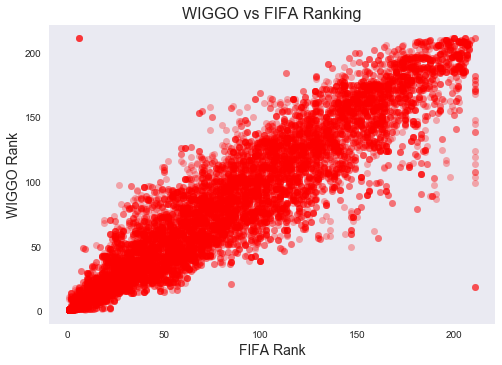

In [141]:
# Compare FIFA to WIGGO Rankings

# Plot
plt.plot(fifa_data['team_a_ranking'].append(fifa_data.team_b_ranking),
         wiggo_data['team_a_ranking'][4735:].append(wiggo_data.team_b_ranking[4735:]), 'ro', alpha=.3)

# Label
plt.title('WIGGO vs FIFA Ranking', fontsize=16)
plt.xlabel('FIFA Rank', fontsize=14)
plt.ylabel('WIGGO Rank', fontsize=14)

plt.grid(False)

plt.savefig('WIGGO_FIFA_Rankings.png')

plt.show()

Unsurprisingly, we see that the WIGGO and FIFA Rankings are highly correlated, but also that they can rank teams quite differently. Generally, though, both ranking systems agree about which teams are better than others.

Note: The points along the right edge of the plot are the result of how WIGGO and FIFA handle new teams. FIFA automatically puts new teams at the bottom of the rankings, whereas WIGGO starts them closer to the middle. These points are scarce, and they are not enormous outliers, so we feel safe including them in our analysis.

Though there are two clear outliers in the corners of the plot, they are vastly outweighed by the other data. Since they will not significantly (if at all) affect our analysis, we are comfortable leaving them in the data set as well.

--------

The following plot shows how WIGGO's *Ratings* relate to FIFA's. Opposite from the Rankings, these point ratings are meant to be an indicator of team strength, and they increase as a team wins games. So, better teams should have higher ratings, and worse teams should have lower ratings.

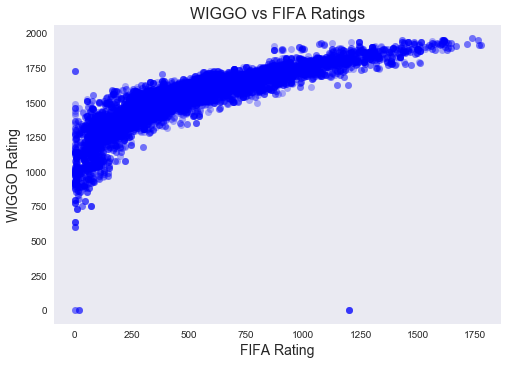

In [142]:
# Compare FIFA to WIGGO Rating Points

# Plot
plt.plot(fifa_data['team_a_points'].append(fifa_data.team_b_points),
         wiggo_data['team_a_points'][4735:].append(wiggo_data.team_b_points[4735:]), 'bo', alpha=.3)

# Label
plt.title('WIGGO vs FIFA Ratings', fontsize=16)
plt.xlabel('FIFA Rating', fontsize=14)
plt.ylabel('WIGGO Rating', fontsize=14)

plt.grid(False)

plt.savefig('WIGGO_FIFA_Ratings.png')

plt.show()

There is also an apparent relationship (although perhaps not linear) between a team's FIFA points and their WIGGO points at any given month.

The three points along y = 0 were exceptions in our matching function, but since it's only three points, we'll go ahead with the analysis.

## III. Logistic Regression

Now that we know how WIGGO's Rankings and Ratings compare to FIFA's, let's see which of the two can make more powerful World Cup predictions. To do this, we can use Multinomial and Logistic Regression.

To simplify the comparison, we will only include the WIGGO and FIFA data in these regressions (i.e. each team's WIGGO Rankings and Ratings, and each team's FIFA Rankings and Ratings). Other predictors like travel distance, type of game, etc. will not be included in this section.

In [143]:
cv = KFold(5, random_state=42)

In [144]:
# Train on Team Rankings and Ratings
fifa_info_train = fifa_train[['team_a_ranking', 'team_a_points',
                          'team_b_ranking', 'team_b_points']]
fifa_info_test = fifa_test[['team_a_ranking', 'team_a_points', 
                            'team_b_ranking', 'team_b_points']]

wiggo_info_train = wiggo_train[['team_a_ranking', 'team_a_points',
                            'team_b_ranking', 'team_b_points']]
wiggo_info_test = wiggo_test[['team_a_ranking', 'team_a_points',
                            'team_b_ranking', 'team_b_points']]

------
Now let's run our Multinomial and OvR Logistic Regressions: one each on just the FIFA data, and one each on the WIGGO data. The classification accuracies of both regressions on the last 2 World Cups are reported below.

Note: We cannot report the FIFA model's accuracy on the last 4 World Cups because FIFA data did not exist until after the 2010 World Cup. For the sake of completeness, and to show the consistency of WIGGO's predictions, though, we additionally show WIGGO's accuracy on the last 4 World Cups.

--------

In [145]:
cv = KFold(5, random_state=42)

# Multinomial Logistic Regression
fifa_mult = LogisticRegressionCV(multi_class='multinomial', penalty='l2', cv=cv)
wiggo_mult = LogisticRegressionCV(multi_class='multinomial', penalty='l2', cv=cv)

# Fit Data
fifa_mult.fit(fifa_info_train, y_train_fifa)
wiggo_mult.fit(wiggo_info_train, y_train_wiggo)

# Get Accuracies
fifa_mult_acc = fifa_mult.score(fifa_info_test, y_test_fifa)
wiggo_mult_acc = wiggo_mult.score(wiggo_info_test[128:], y_test_wiggo[128:])
wiggo_mult_acc_full = wiggo_mult.score(wiggo_info_test, y_test_wiggo)

print('Multinomial Classification Accuracy on World Cup Matches with FIFA Rankings  (Last 2 World Cups):',
      round(fifa_mult_acc, 4))
print('Multinomial Classification Accuracy on World Cup Matches with WIGGO Rankings (Last 2 World Cups):',
      round(wiggo_mult_acc, 4))
print('Multinomial Classification Accuracy on World Cup Matches with WIGGO Rankings (Last 4 World Cups):',
      round(wiggo_mult_acc_full, 4))

Multinomial Classification Accuracy on World Cup Matches with FIFA Rankings  (Last 2 World Cups): 0.5391
Multinomial Classification Accuracy on World Cup Matches with WIGGO Rankings (Last 2 World Cups): 0.5859
Multinomial Classification Accuracy on World Cup Matches with WIGGO Rankings (Last 4 World Cups): 0.5859


In [146]:
# One v Rest Logistic Regression
fifa_ovr = LogisticRegressionCV(multi_class='ovr', penalty='l2', cv=cv)
wiggo_ovr = LogisticRegressionCV(multi_class='ovr', penalty='l2', cv=cv)

# Fit Data
fifa_ovr.fit(fifa_info_train, y_train_fifa)
wiggo_ovr.fit(wiggo_info_train, y_train_wiggo)

# Get Accuracy
fifa_ovr_acc = fifa_ovr.score(fifa_info_test, y_test_fifa)
wiggo_ovr_acc = wiggo_ovr.score(wiggo_info_test[128:], y_test_wiggo[128:])
wiggo_ovr_acc_full = wiggo_ovr.score(wiggo_info_test, y_test_wiggo)


print('OvR Classification Accuracy on World Cup Matches with FIFA Rankings  (Last 2 World Cups):',
      round(fifa_ovr_acc, 4))
print('OvR Classification Accuracy on World Cup Matches with WIGGO Rankings (Last 2 World Cups):',
      round(wiggo_ovr_acc, 4))
print('OvR Classification Accuracy on World Cup Matches with WIGGO Rankings (Last 4 World Cups):',
      round(wiggo_ovr_acc_full, 4))

OvR Classification Accuracy on World Cup Matches with FIFA Rankings  (Last 2 World Cups): 0.5625
OvR Classification Accuracy on World Cup Matches with WIGGO Rankings (Last 2 World Cups): 0.5859
OvR Classification Accuracy on World Cup Matches with WIGGO Rankings (Last 4 World Cups): 0.5859


<HR>
In both regressions, the WIGGO data outperformed the FIFA data by a significant margin. While this lone suggests that WIGGO is ths more accurate predictor of the two, there are more regression techniques that we can use to confirm this output.
</HR>

## IV. Ridge Regression: Classification with Penalization

Another way for us to test these two ranking systems is to include both WIGGO and FIFA in a model that uses Regularization, and see which of the coefficients for the two sets of predictors gets shrunk toward 0. Here, we will run a Ridge Regression on all the predictors in the dataset, though we will care most about the ones that involve WIGGO and FIFA data.

In [147]:
# Join datasets
joint_data = wiggo_data[4735:]

# Relabel WIGGO Info
joint_data = joint_data.rename(index=str, columns={"team_a_ranking": "wiggo_a_ranking",
                                                   "team_b_ranking": "wiggo_b_ranking",
                                                   "team_a_points": "wiggo_a_points",
                                                   "team_b_points": "wiggo_b_points"})
# Add FIFA Info
joint_data['fifa_a_ranking'] = fifa_data.team_a_ranking.values
joint_data['fifa_a_points'] = fifa_data.team_a_points.values
joint_data['fifa_b_ranking'] = fifa_data.team_b_ranking.values
joint_data['fifa_b_points'] = fifa_data.team_b_points.values

# Drop Categorical (already have dummies)
joint_data = joint_data.drop(columns={"Type"})

joint_data.describe()

,HomeAdv,Win,PrevDiffHome1,PrevDiffAway1,PrevDiffHome2,PrevDiffAway2,PrevDiffHome3,PrevDiffAway3,PrevDiffHome4,PrevDiffAway4,...,Cont,ContQ,FSS,KFC,WM,WM-Q,fifa_a_ranking,fifa_a_points,fifa_b_ranking,fifa_b_points
count,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,...,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000,6234.000000
mean,0.713346,0.194257,0.034970,0.000962,0.040584,-0.000321,0.068335,-0.018608,0.064164,-0.011389,...,0.059673,0.161052,0.493423,0.005133,0.020533,0.260186,84.358037,509.415055,87.097530,488.747241
std,0.476084,0.849284,2.214126,2.192705,2.208262,2.192486,2.205069,2.199859,2.255618,2.166508,...,0.236899,0.367609,0.499997,0.071468,0.141825,0.438771,55.385667,344.585517,55.029579,332.355653
min,-1.000000,-1.000000,-16.000000,-12.000000,-16.000000,-12.000000,-15.000000,-15.000000,-17.000000,-10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,250.480000,40.000000,239.200000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.000000,434.755000,81.000000,421.070000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,126.000000,713.742500,129.000000,676.065000
max,1.000000,1.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,211.000000,1775.030000,211.000000,1775.030000


In [148]:
# Reorder Columns

joint_data = joint_data[['Win',
 'HomeAdv',
 'PrevDiffHome1',
 'PrevDiffHome2',
 'PrevDiffHome3',
 'PrevDiffHome4',
 'PrevDiffHome5',
 'PrevDiffHome6',
 'PrevDiffHome7',
 'PrevDiffHome8',
 'PrevDiffHome9',
 'PrevDiffHome10',
 'PrevDiffAway1',
 'PrevDiffAway2',
 'PrevDiffAway3',
 'PrevDiffAway4',
 'PrevDiffAway5',
 'PrevDiffAway6',
 'PrevDiffAway7',
 'PrevDiffAway8',
 'PrevDiffAway9',
 'PrevDiffAway10',
 'dist_home',
 'TravelHome',
 'TZDeltaHome',
 'dist_away',
 'TravelAway',
 'TZDeltaAway',
 'Cont',
 'ContQ',
 'FSS',
 'KFC',
 'WM',
 'WM-Q',
 'wiggo_a_ranking',
 'fifa_a_ranking',
 'wiggo_b_ranking',
 'fifa_b_ranking',
 'wiggo_a_points',
 'fifa_a_points',
 'wiggo_b_points',
 'fifa_b_points']]

In [149]:
# Train on Non-World Cup Matches, Test on World Cup
y_train = joint_data.Win[joint_data.WM == 0].values + 1
y_test = joint_data.Win[(joint_data.WM == 1)].values + 1

x_train = joint_data[joint_data.WM == 0].drop(columns={'Win'})
x_test = joint_data[(joint_data.WM == 1)].drop(columns={'Win'})

In [150]:
lambdas = [.001, .005, .1, .5, 1, 5, 10, 50, 100, 150, 200, 250]

# declare and pass a KFold object to properly shuffle the training data 
# and/or set the random state
splitter = KFold(5, random_state=42, shuffle=True)

# find the best shrinkage parameter
ridgeCV = RidgeClassifierCV(alphas=lambdas, cv=splitter)
ridgeCV.fit(x_train, y_train)

R_lambda = ridgeCV.alpha_

print('The shrinkage parameter {} best fits our Ridge Regression model.'
      .format(R_lambda))

The shrinkage parameter 200 best fits our Ridge Regression model.


In [151]:
print("Full Predictors:", ridgeCV.score(x_test[:], y_test[:]))
print("Rankings Only:", ridgeCV_ranking.score(ranking_test[:], y_test[:]))
print("Points Only:", ridgeCV_points.score(points_test[:], y_test[:]))

Full Predictors: 0.5859375
Rankings Only: 0.546875
Points Only: 0.578125


--------------
The Ridge model performs fairly well, though, this information isn't terribly useful for comparing WIGGO and FIFA. Instead, we need to investigate the coefficients that the model assigns to each of the predictors.

The following bar plots show how important the WIGGO/FIFA Rankings and Ratings are to the Ridge Model we just fit. The first plot displays the coefficients of each predictor when the model predicts the probability that Team A *loses*, and the second plot shows the same coefficients when the model finds the probability that Team A *wins*.

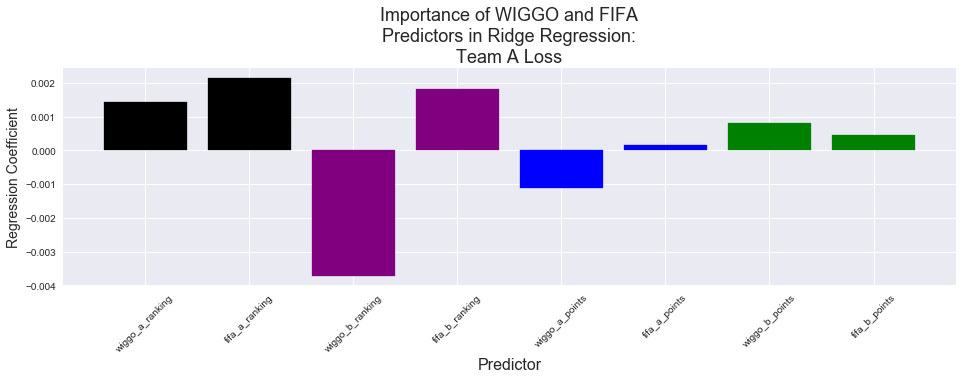

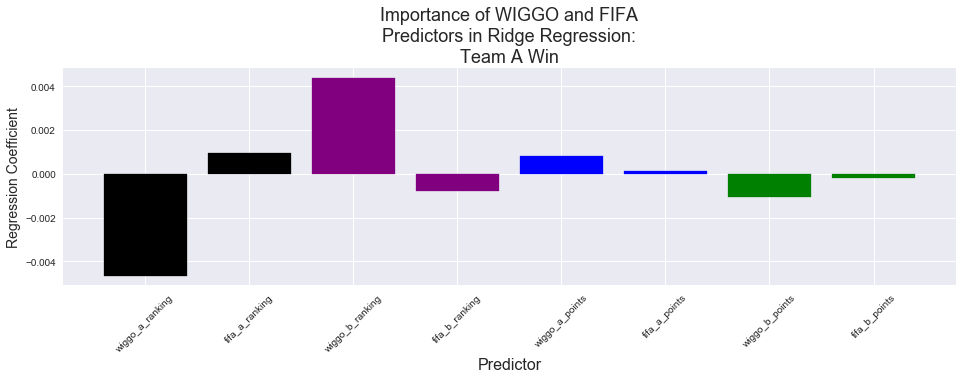

In [152]:
# Plot

clss = 'Team A Loss'
for i in [0, 2]:
    
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    
    # Plot Regression Coefficients
    barlist = plt.bar(x_train.columns.values[33:44], ridgeCV.coef_[i][33:44])
    barlist[0].set_color('black')
    barlist[1].set_color('black')
    barlist[2].set_color('purple')
    barlist[3].set_color('purple')
    barlist[4].set_color('blue')
    barlist[5].set_color('blue')
    barlist[6].set_color('green')
    barlist[7].set_color('green')
    
    if i == 2:
        clss = 'Team A Win'
    
    # Label
    plt.title("Importance of WIGGO and FIFA\nPredictors in Ridge Regression:\n{}".format(clss), fontsize=18)
    plt.xlabel('Predictor', fontsize=16)
    plt.ylabel('Regression Coefficient', fontsize=14)
    plt.xticks(rotation='45')

    plt.show()

There are two aspects of these bar graphs that we should pay particular attention to: the magnitude, and the direction of each bar. Higher magnitudes indicate that a predictor is more important to the model, and the direction of the bar indicates the sign of the relationship between the response variable and the predictor.

At a first glance, for both plots and nearly every pair of WIGGO and FIFA predictor, we can see that the Ridge model prioritizes the Wiggo version over the FIFA one (shown by their higher magnitudes). Furthermore, each of the WIGGO coefficients point in the direction that we would expect them to point, given the outcome that they are predicting.

For example, let's look at the second plot, which shows how the model values these predictors when it predicts the probability that **Team A Wins**:
* We would expect Team A to win more often when its ranking is low (better), so we should see a negative relationship between these two variables. Indeed, Team A's WIGGO ranking has this relationship. Its FIFA ranking does not.
* Accordingly, we would expect Team A to win more often when Team B's ranking is high (worse). The model interprets Team B's WIGGO ranking correctly; not so for the FIFA ranking.
* Opposite from ranking, a team's rating (points) increases as a team gets stronger. Thus, we'd expect that teams with higher ratings will win more often, and teams with lower ratings will win less often. The coefficents of the WIGGO data present this accurately

Based on this output, it is safe to conclude that the Ridge model weights the WIGGO data much more heavily than it does the FIFA data.

--------

Though, we can still get more precise with our analysis. Let's try running a Ridge regression on just the WIGGO and FIFA Rankings, and then another on just the WIGGO and FIFA Ratings.

In [153]:
ranking_train = x_train[['fifa_a_ranking', 'wiggo_a_ranking',
                         'fifa_b_ranking', 'wiggo_b_ranking']]

ranking_test = x_test[['fifa_a_ranking', 'wiggo_a_ranking',
                         'fifa_b_ranking', 'wiggo_b_ranking']]

points_train = x_train[['fifa_a_points', 'wiggo_a_points',
                       'fifa_b_points', 'wiggo_b_points']]

points_test = x_test[['fifa_a_points', 'wiggo_a_points',
                       'fifa_b_points', 'wiggo_b_points']]

info_train = ranking_train.join(points_train)
info_test = ranking_test.join(points_test)

info_train.head()

,fifa_a_ranking,wiggo_a_ranking,fifa_b_ranking,wiggo_b_ranking,fifa_a_points,wiggo_a_points,fifa_b_points,wiggo_b_points
4735,114.0,105.0,158.0,156.0,260.28,1459.749020,112.14,1315.418259
4736,120.0,101.0,129.0,117.0,245.77,1478.784997,208.71,1438.584100
4737,108.0,94.0,88.0,87.0,298.87,1501.046264,364.41,1522.173904
4738,101.0,80.0,98.0,118.0,325.01,1536.269464,328.96,1432.569466
4739,106.0,111.0,158.0,140.0,307.77,1454.906951,111.79,1373.481424


In [154]:
lambdas = [.001, 1, 100, 1000, 10000, 50000, 100000]

# declare and pass a KFold object to properly shuffle the training data 
# and/or set the random state
splitter = KFold(5, random_state=42, shuffle=True)

# find the best shrinkage parameter
ridgeCV_ranking = RidgeClassifierCV(alphas=lambdas, cv=splitter)
ridgeCV_ranking.fit(ranking_train, y_train)

Ranking_lambda = ridgeCV_ranking.alpha_

print('The shrinkage parameter {} best fits our Ridge Regression model.'
      .format(Ranking_lambda))

The shrinkage parameter 50000 best fits our Ridge Regression model.


------
The following bar plot is built in a similar fashion to the previous one, though it shows the results of a Ridge regression model that was fit on just the Ranking data.

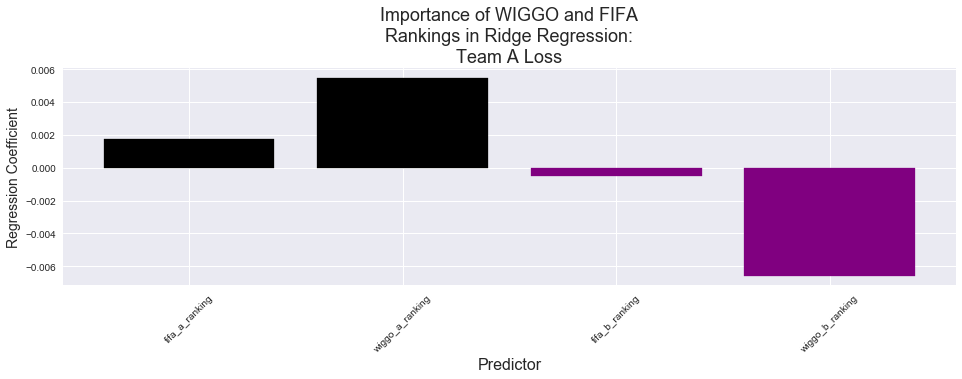

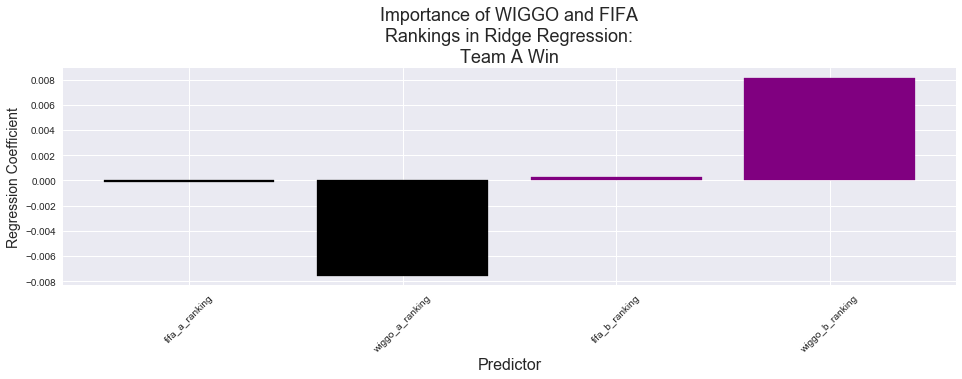

In [155]:
clss='Team A Loss'

for i in [0, 2]:
    
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    
    # Plot Regression Coefficients
    barlist = plt.bar(ranking_train.columns.values, ridgeCV_ranking.coef_[i])
    
    barlist[0].set_color('black')
    barlist[1].set_color('black')
    barlist[2].set_color('purple')
    barlist[3].set_color('purple')

    if i==2: clss = 'Team A Win'
    
    # Label
    plt.title("Importance of WIGGO and FIFA\nRankings in Ridge Regression:\n{}".format(clss), fontsize=18)
    plt.xlabel('Predictor', fontsize=16)
    plt.ylabel('Regression Coefficient', fontsize=14)
    plt.xticks(rotation='45')
    
    plt.show()

_____________
As we would expect, the Ridge model values the WIGGO data far more than it values the FIFA data. Each of WIGGO's coefficients are much greater than FIFA's are, and all of WIGGO's bars point in the expected direction.

Now let's do the same with the WIGGO/FIFA Ratings:

In [156]:
lambdas = [.001, 1, 100, 1000, 10000, 50000, 100000]

# declare and pass a KFold object to properly shuffle the training data 
# and/or set the random state
splitter = KFold(5, random_state=42, shuffle=True)

# find the best shrinkage parameter
ridgeCV_points = RidgeClassifierCV(alphas=lambdas, cv=splitter)
ridgeCV_points.fit(points_train, y_train)

Points_lambda = ridgeCV_points.alpha_

print('The shrinkage parameter {} best fits our Ridge Regression model.'
      .format(Points_lambda))

The shrinkage parameter 100000 best fits our Ridge Regression model.


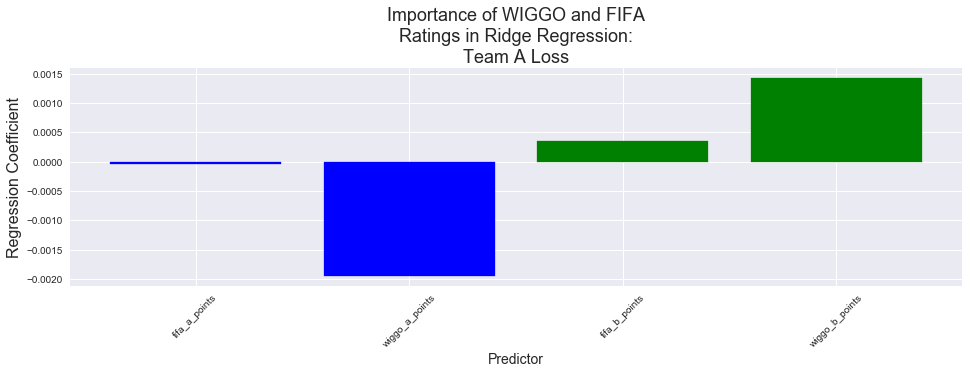

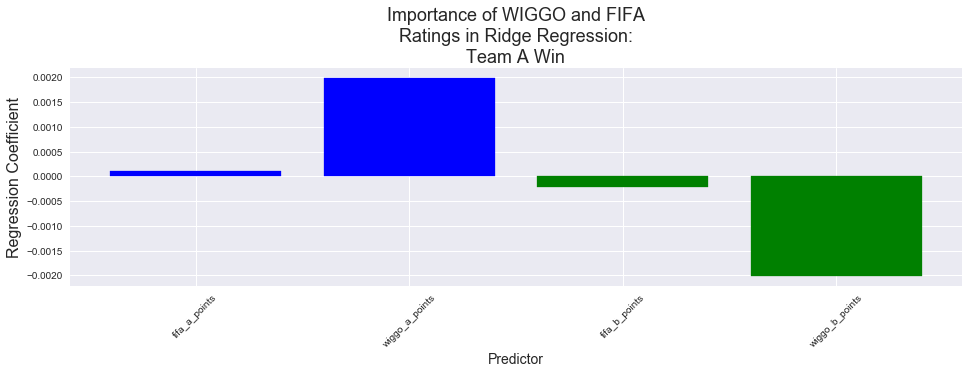

In [157]:
clss = 'Team A Loss'

for i in [0, 2]:
    
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    
    # Plot Regression Coefficients
    barlist = plt.bar(points_test.columns.values, ridgeCV_points.coef_[i], color='black')
    
    barlist[0].set_color('blue')
    barlist[1].set_color('blue')
    barlist[2].set_color('green')
    barlist[3].set_color('green')

    if i==2: clss = 'Team A Win'

    # Label
    plt.title("Importance of WIGGO and FIFA\nRatings in Ridge Regression:\n{}".format(clss), fontsize=18)
    plt.xlabel('Predictor', fontsize=14)
    plt.ylabel('Regression Coefficient', fontsize=16)
    plt.xticks(rotation='45')

    plt.show()

----------
And again, the model shows exactly what we would expect.

## Conclusion

By now, it is obvious that WIGGO provides more prediction power than FIFA does when it comes to predicting World Cup games. Each regression, whether trained on the Rankings, the Ratings, or all the data combined, indicates that the WIGGO data is more closely related to the outcomes of World Cup matches than the FIFA data is. As such, we will use the WIGGO data as our main indicator of team strength as we build our final model.